In [23]:
import contextlib
import io

f = io.StringIO()
with contextlib.redirect_stdout(f):
    import numpy as np
    import pandas as pd
    import import_ipynb
    from content_table_updated import *
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def calculateRMSE(pred, df):
    original = df.pivot(index='u_id', columns='a_id', values='score').fillna(0).values
    mask = original > 0
    pred = pred[mask]
    original = original[mask]
    return np.sqrt(np.mean((np.asarray(pred) - np.asarray(original)) ** 2))

In [3]:
df_1 = pd.read_csv('data/100x100.csv')
df_2 = pd.read_csv('data/100x100_2.csv')
results = []

# Part 1: Full Dataset Testing

In this section, we'll evaluate each model on the full datasets without splitting.

## Baseline Model (Full Datasets)

In [4]:
# Baseline model lambda = 5, using dataset 1 (full dataset)
baseline_matrix_1 = baseline_model(5, df_1)
rmse = calculateRMSE(baseline_matrix_1, df_1)
print(f"Baseline model on full Dataset 1 RMSE: {rmse}")
results.append({"Model": "Baseline", "Dataset": "Dataset 1", "Evaluation": "Full", "RMSE": rmse})

Baseline model on full Dataset 1 RMSE: 1.4950463224771797


In [5]:
# Baseline model lambda = 5, using dataset 2 (full dataset)
baseline_matrix_2 = baseline_model(5, df_2)
rmse = calculateRMSE(baseline_matrix_2, df_2)
print(f"Baseline model on full Dataset 2 RMSE: {rmse}")
results.append({"Model": "Baseline", "Dataset": "Dataset 2", "Evaluation": "Full", "RMSE": rmse})

Baseline model on full Dataset 2 RMSE: 1.5656342546196638


## ALS Model (Full Datasets)

In [6]:
# ALS at rank 20, 1000 iterations, using dataset 1 (full dataset)
X, Y = als(df_1, 20, 1000)
als_matrix_1 = X @ Y.T
rmse = calculateRMSE(als_matrix_1, df_1)
print(f"ALS model on full Dataset 1 RMSE: {rmse}")
results.append({"Model": "ALS", "Dataset": "Dataset 1", "Evaluation": "Full", "RMSE": rmse})

ALS model on full Dataset 1 RMSE: 0.01776288181254805


In [9]:
# ALS at rank 20, 1000 iterations, using dataset 2 (full dataset)
X, Y = als(df_2, 20, 1000)
als_matrix_2 = X @ Y.T
rmse = calculateRMSE(als_matrix_2, df_2)
print(f"ALS model on full Dataset 2 RMSE: {rmse}")
results.append({"Model": "ALS", "Dataset": "Dataset 2", "Evaluation": "Full", "RMSE": rmse})

ALS model on full Dataset 2 RMSE: 0.021616830663367243


## Spectral Regularization Model (Full Datasets)

In [10]:
# Spectral Regularization Model at lambda 5, using dataset 1 (full dataset)
spectral_matrix_1 = spectral_regularization_model(5, df_1)
rmse = calculateRMSE(spectral_matrix_1, df_1)
print(f"Spectral Regularization model on full Dataset 1 RMSE: {rmse}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 1", "Evaluation": "Full", "RMSE": rmse})

Spectral Regularization model on full Dataset 1 RMSE: 0.7436389012303583


In [11]:
# Spectral Regularization Model at lambda 5, using dataset 2 (full dataset)
spectral_matrix_2 = spectral_regularization_model(5, df_2)
rmse = calculateRMSE(spectral_matrix_2, df_2)
print(f"Spectral Regularization model on full Dataset 2 RMSE: {rmse}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 2", "Evaluation": "Full", "RMSE": rmse})

Spectral Regularization model on full Dataset 2 RMSE: 0.9385516001401082


## Nuclear Norm Model (Full Datasets)

In [24]:
# Nuclear norm model, using dataset 1 (full dataset)
nuclear_matrix_1 = nuclear_norm_model_df(df_1)
rmse = calculateRMSE(nuclear_matrix_1, df_1)
print(f"Nuclear Norm model on full Dataset 1 RMSE: {rmse}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 1", "Evaluation": "Full", "RMSE": rmse})

Nuclear Norm model on full Dataset 1 RMSE: 6.675280772867334e-09


In [25]:
# Nuclear norm model, using dataset 2 (full dataset)
nuclear_matrix_2 = nuclear_norm_model_df(df_2)
rmse = calculateRMSE(nuclear_matrix_2, df_2)
print(f"Nuclear Norm model on full Dataset 2 RMSE: {rmse}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 2", "Evaluation": "Full", "RMSE": rmse})

Nuclear Norm model on full Dataset 2 RMSE: 4.3742719585052305e-09


# Part 2: Train/Test Split Evaluation

In this section, we'll train models on the training sets and evaluate them on both training and test sets.

In [26]:
# data is so sparse that using sklearn's train_test_split always ends up with different sets of user and anime ids,
# that's why we wrote a custom one to ensure that all user and anime ids are present
# in both train and test sets

def train_test_split(df, test_size=0.2, random_state=42):
    train_df = df.copy()
    indices = df.index.tolist()
    np.random.seed(random_state)
    np.random.shuffle(indices)
    # choose first (1-test_size)% of the indices for training, don't remove the rest, assign them zeros
    # for test set, assign the first (1-test_size)% zeros
    train_indices = indices[:int(len(indices) * (1 - test_size))]
    test_indices = indices[int(len(indices) * (1 - test_size)):]
    train_df.loc[train_indices, 'score'] = df.loc[train_indices, 'score']
    test_df = df.copy()
    test_df.loc[train_indices, 'score'] = 0
    train_df.loc[test_indices, 'score'] = 0
    
    return train_df, test_df

df_1_train, df_1_test = train_test_split(df_1)
df_2_train, df_2_test = train_test_split(df_2)

df_1_full_matrix = df_1.pivot(index='u_id', columns='a_id', values='score').fillna(0)
df_1_train_matrix = df_1_train.pivot(index='u_id', columns='a_id', values='score').fillna(0)
df_1_test_matrix = df_1_test.pivot(index='u_id', columns='a_id', values='score').fillna(0)

df_2_full_matrix = df_2.pivot(index='u_id', columns='a_id', values='score').fillna(0)
df_2_train_matrix = df_2_train.pivot(index='u_id', columns='a_id', values='score').fillna(0)
df_2_test_matrix = df_2_test.pivot(index='u_id', columns='a_id', values='score').fillna(0)

# assert all have the every user and anime id lists
assert df_1_full_matrix.shape[0] == df_1_train_matrix.shape[0] == df_1_test_matrix.shape[0]
assert df_1_full_matrix.shape[1] == df_1_train_matrix.shape[1] == df_1_test_matrix.shape[1]

assert df_2_full_matrix.shape[0] == df_2_train_matrix.shape[0] == df_2_test_matrix.shape[0]
assert df_2_full_matrix.shape[1] == df_2_train_matrix.shape[1] == df_2_test_matrix.shape[1]

# assert train and test is correctly split by checking that the sum of the train and test matrices 
# is equal to the full matrix
assert np.all(df_1_full_matrix.values == df_1_train_matrix.values + df_1_test_matrix.values)
assert np.all(df_2_full_matrix.values == df_2_train_matrix.values + df_2_test_matrix.values)

## Baseline Model (Train/Test)

In [27]:
# Baseline model on training/test sets for dataset 1
baseline_matrix_1_train = baseline_model(5, df_1_train)
# Training set evaluation
rmse_train = calculateRMSE(baseline_matrix_1_train, df_1_train)
print(f"Baseline model on Dataset 1 Training RMSE: {rmse_train}")
results.append({"Model": "Baseline", "Dataset": "Dataset 1", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(baseline_matrix_1_train, df_1_test)
print(f"Baseline model on Dataset 1 Test RMSE: {rmse_test}")
results.append({"Model": "Baseline", "Dataset": "Dataset 1", "Evaluation": "Test", "RMSE": rmse_test})

Baseline model on Dataset 1 Training RMSE: 2.1526451289822752
Baseline model on Dataset 1 Test RMSE: 2.7775959301225828


In [28]:
# Baseline model on training/test sets for dataset 2
baseline_matrix_2_train = baseline_model(5, df_2_train)
# Training set evaluation
rmse_train = calculateRMSE(baseline_matrix_2_train, df_2_train)
print(f"Baseline model on Dataset 2 Training RMSE: {rmse_train}")
results.append({"Model": "Baseline", "Dataset": "Dataset 2", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(baseline_matrix_2_train, df_2_test)
print(f"Baseline model on Dataset 2 Test RMSE: {rmse_test}")
results.append({"Model": "Baseline", "Dataset": "Dataset 2", "Evaluation": "Test", "RMSE": rmse_test})

Baseline model on Dataset 2 Training RMSE: 2.1750590322526087
Baseline model on Dataset 2 Test RMSE: 2.8070039334331316


## ALS Model (Train/Test)

In [29]:
# ALS on training/test sets for dataset 1
X_train_1, Y_train_1 = als(df_1_train, 20, 1000)
als_matrix_1_train = X_train_1 @ Y_train_1.T
# Training set evaluation
rmse_train = calculateRMSE(als_matrix_1_train, df_1_train)
print(f"ALS model on Dataset 1 Training RMSE: {rmse_train}")
results.append({"Model": "ALS", "Dataset": "Dataset 1", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(als_matrix_1_train, df_1_test)
print(f"ALS model on Dataset 1 Test RMSE: {rmse_test}")
results.append({"Model": "ALS", "Dataset": "Dataset 1", "Evaluation": "Test", "RMSE": rmse_test})

ALS model on Dataset 1 Training RMSE: 0.018816986709706433
ALS model on Dataset 1 Test RMSE: 1.848435521145162


In [30]:
# ALS on training/test sets for dataset 2
X_train_2, Y_train_2 = als(df_2_train, 20, 1000)
als_matrix_2_train = X_train_2 @ Y_train_2.T
# Training set evaluation
rmse_train = calculateRMSE(als_matrix_2_train, df_2_train)
print(f"ALS model on Dataset 2 Training RMSE: {rmse_train}")
results.append({"Model": "ALS", "Dataset": "Dataset 2", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(als_matrix_2_train, df_2_test)
print(f"ALS model on Dataset 2 Test RMSE: {rmse_test}")
results.append({"Model": "ALS", "Dataset": "Dataset 2", "Evaluation": "Test", "RMSE": rmse_test})

ALS model on Dataset 2 Training RMSE: 0.02418875953617675
ALS model on Dataset 2 Test RMSE: 2.1535022941882134


## Spectral Regularization Model (Train/Test)

In [31]:
# Spectral Regularization on training/test sets for dataset 1
spectral_matrix_1_train = spectral_regularization_model(5, df_1_train)
# Training set evaluation
rmse_train = calculateRMSE(spectral_matrix_1_train, df_1_train)
print(f"Spectral Regularization model on Dataset 1 Training RMSE: {rmse_train}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 1", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(spectral_matrix_1_train, df_1_test)
print(f"Spectral Regularization model on Dataset 1 Test RMSE: {rmse_test}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 1", "Evaluation": "Test", "RMSE": rmse_test})

Spectral Regularization model on Dataset 1 Training RMSE: 0.7433341532764499
Spectral Regularization model on Dataset 1 Test RMSE: 6.7852614402171545


In [32]:
# Spectral Regularization on training/test sets for dataset 2
spectral_matrix_2_train = spectral_regularization_model(5, df_2_train)
# Training set evaluation
rmse_train = calculateRMSE(spectral_matrix_2_train, df_2_train)
print(f"Spectral Regularization model on Dataset 2 Training RMSE: {rmse_train}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 2", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(spectral_matrix_2_train, df_2_test)
print(f"Spectral Regularization model on Dataset 2 Test RMSE: {rmse_test}")
results.append({"Model": "Spectral Regularization", "Dataset": "Dataset 2", "Evaluation": "Test", "RMSE": rmse_test})

Spectral Regularization model on Dataset 2 Training RMSE: 1.0001991203194858
Spectral Regularization model on Dataset 2 Test RMSE: 6.583495856342865


## Nuclear Norm Model (Train/Test)

In [33]:
# Nuclear Norm on training/test sets for dataset 1
nuclear_matrix_1_train = nuclear_norm_model_df(df_1_train)
# Training set evaluation
rmse_train = calculateRMSE(nuclear_matrix_1_train, df_1_train)
print(f"Nuclear Norm model on Dataset 1 Training RMSE: {rmse_train}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 1", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(nuclear_matrix_1_train, df_1_test)
print(f"Nuclear Norm model on Dataset 1 Test RMSE: {rmse_test}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 1", "Evaluation": "Test", "RMSE": rmse_test})

Nuclear Norm model on Dataset 1 Training RMSE: 1.498717793948777e-09
Nuclear Norm model on Dataset 1 Test RMSE: 7.620653777170292


In [34]:
# Nuclear Norm on training/test sets for dataset 2
nuclear_matrix_2_train = nuclear_norm_model_df(df_2_train)
# Training set evaluation
rmse_train = calculateRMSE(nuclear_matrix_2_train, df_2_train)
print(f"Nuclear Norm model on Dataset 2 Training RMSE: {rmse_train}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 2", "Evaluation": "Training", "RMSE": rmse_train})
# Test set evaluation
rmse_test = calculateRMSE(nuclear_matrix_2_train, df_2_test)
print(f"Nuclear Norm model on Dataset 2 Test RMSE: {rmse_test}")
results.append({"Model": "Nuclear Norm", "Dataset": "Dataset 2", "Evaluation": "Test", "RMSE": rmse_test})

Nuclear Norm model on Dataset 2 Training RMSE: 3.69949727318972e-09
Nuclear Norm model on Dataset 2 Test RMSE: 7.414480581618638


In [35]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df.head(10)

,Model,Dataset,Evaluation,RMSE
0,Baseline,Dataset 1,Full,1.495046e+00
1,Baseline,Dataset 2,Full,1.565634e+00
2,ALS,Dataset 1,Full,1.776288e-02
3,ALS,Dataset 2,Full,2.161683e-02
4,Spectral Regularization,Dataset 1,Full,7.436389e-01
5,Spectral Regularization,Dataset 2,Full,9.385516e-01
6,Nuclear Norm,Dataset 1,Full,6.675281e-09
7,Nuclear Norm,Dataset 2,Full,4.374272e-09
8,Baseline,Dataset 1,Training,2.152645e+00
9,Baseline,Dataset 1,Test,2.777596e+00


In [36]:
# Create a pivot table for easier comparison
pivot_df = results_df.pivot_table(index=['Model', 'Dataset'], columns='Evaluation', values='RMSE')
pivot_df

Evaluation                                 Full      Test      Training
Model                   Dataset                                        
ALS                     Dataset 1  1.776288e-02  1.848436  1.881699e-02
                        Dataset 2  2.161683e-02  2.153502  2.418876e-02
Baseline                Dataset 1  1.495046e+00  2.777596  2.152645e+00
                        Dataset 2  1.565634e+00  2.807004  2.175059e+00
Nuclear Norm            Dataset 1  6.675281e-09  7.620654  1.498718e-09
                        Dataset 2  4.374272e-09  7.414481  3.699497e-09
Spectral Regularization Dataset 1  7.436389e-01  6.785261  7.433342e-01
                        Dataset 2  9.385516e-01  6.583496  1.000199e+00

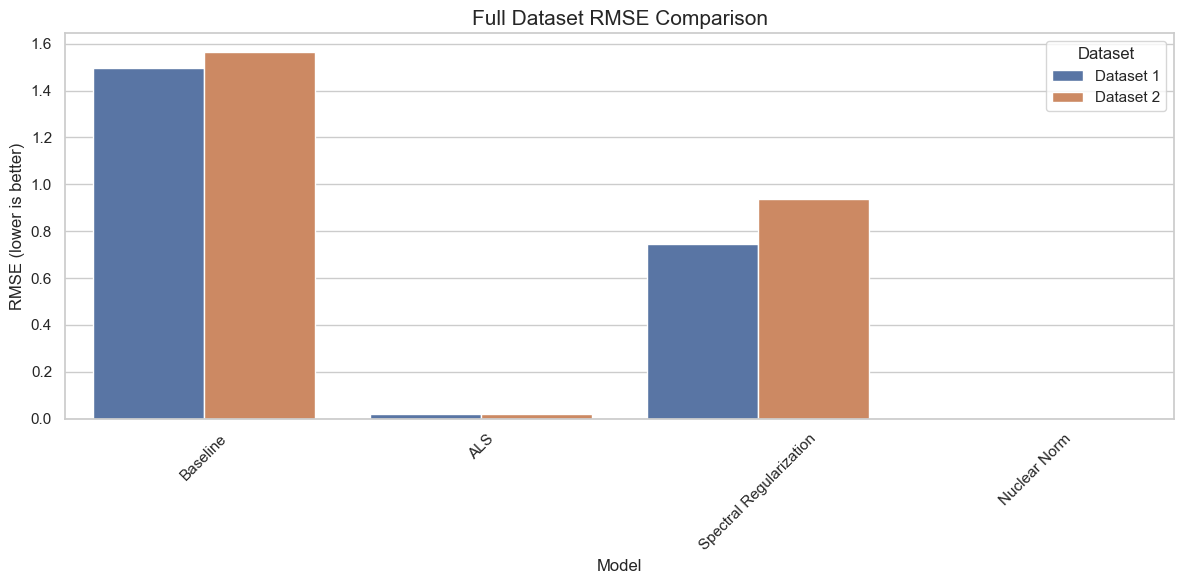

In [37]:
# Compare full dataset results
plt.figure(figsize=(12, 6))
full_df = results_df[results_df['Evaluation'] == 'Full']
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.barplot(x='Model', y='RMSE', hue='Dataset', data=full_df)
plt.title('Full Dataset RMSE Comparison', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE (lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

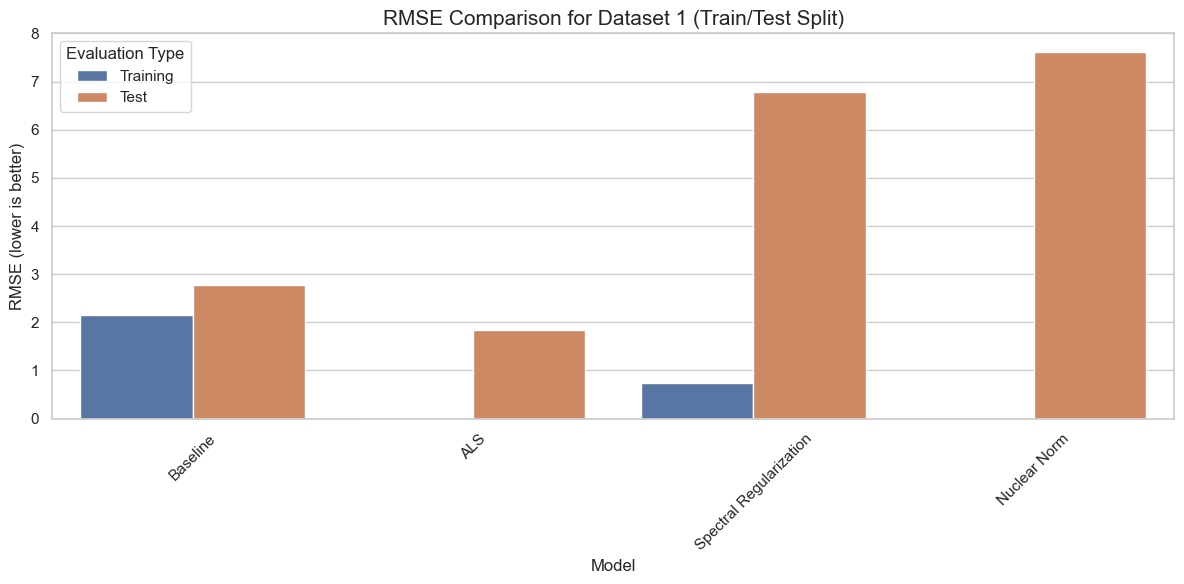

In [38]:
# Plot Dataset 1 results from Train/Test evaluation
plt.figure(figsize=(12, 6))
dataset1_df = results_df[(results_df['Dataset'] == 'Dataset 1') & (results_df['Evaluation'] != 'Full')]
sns.barplot(x='Model', y='RMSE', hue='Evaluation', data=dataset1_df)
plt.title('RMSE Comparison for Dataset 1 (Train/Test Split)', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE (lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Evaluation Type')
plt.tight_layout()
plt.show()

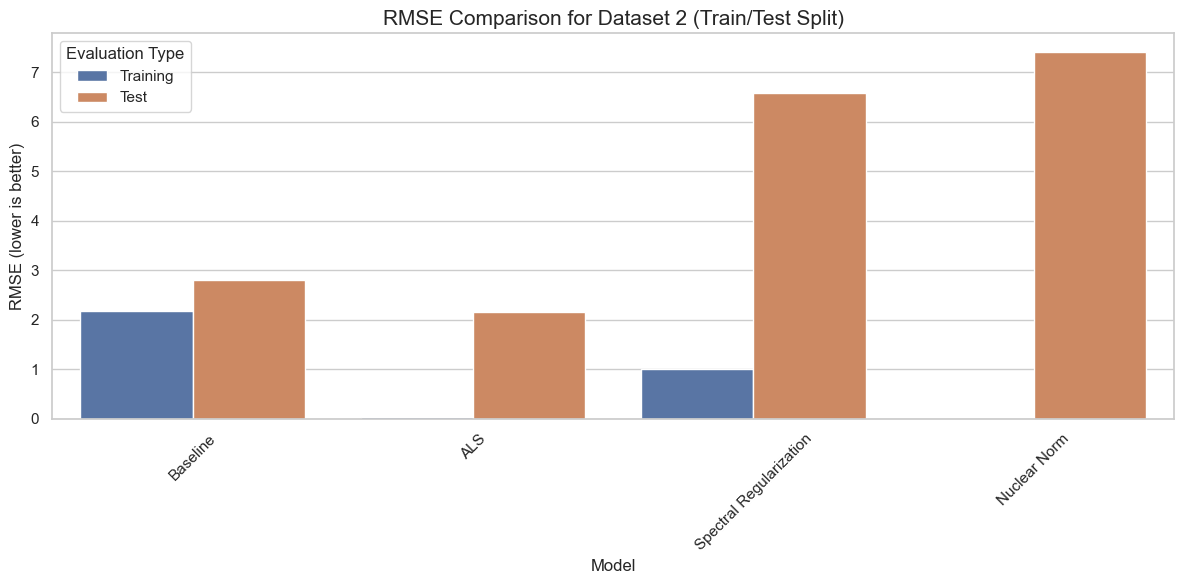

In [39]:
# Plot Dataset 2 results from Train/Test evaluation
plt.figure(figsize=(12, 6))
dataset2_df = results_df[(results_df['Dataset'] == 'Dataset 2') & (results_df['Evaluation'] != 'Full')]
ax = sns.barplot(x='Model', y='RMSE', hue='Evaluation', data=dataset2_df)
plt.title('RMSE Comparison for Dataset 2 (Train/Test Split)', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE (lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Evaluation Type')
plt.tight_layout()
plt.show()